# Benchmark Data Visualization
This notebook compares EC and Replication benchmark results for `success_performance.med`, `success_performance.p(90)`, and `reqs.rate`.

For better visualization, it generates:
- One chart for each metric (med, p90, reqs.rate), comparing EC and Replication for each payload size and virtual user combination.

In [5]:
import json
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your benchmark results directory
results_dir = './results/'
ec_pattern = results_dir + 'erasure/_system_*_*.json'
replication_pattern = results_dir + 'replication/_system_*_*.json'

# Helper to extract data from files

def extract_data(files, system_type):
    data = []
    for file in files:
        match = re.search(r'_system_(.+?)_(\d+)vu\.json', file)
        if not match:
            continue
        payload_size = match.group(1)
        if payload_size.endswith('b'):
            payload_size = payload_size[:-1]
        try:
            payload_size = int(payload_size)
        except ValueError:
            pass
        virtual_user = match.group(2)
        with open(file) as f:
            j = json.load(f)
            med = j['summary']['success_performance']['med']
            p90 = j['summary']['success_performance']['p(90)']
            avg = j['summary']['success_performance'].get('avg', None)
            rate = j['summary']['reqs']['rate']
            data.append({
                'system': system_type,
                'payload_size': payload_size,
                'virtual_user': int(virtual_user),
                'med': med,
                'p90': p90,
                'avg': avg,
                'rate': rate
            })
    return data

# Collect EC and Replication data
files_ec = glob.glob(ec_pattern)
files_replication = glob.glob(replication_pattern)
data = extract_data(files_ec, 'EC') + extract_data(files_replication, 'Replication')
df = pd.DataFrame(data)
if not df.empty:
    # Sort by payload_size, then virtual_user, then system for grouped comparison
    df = df.sort_values(['payload_size', 'virtual_user', 'system'])
    df['combo'] = df.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
    df.reset_index(drop=True, inplace=True)
df

,system,payload_size,virtual_user,med,p90,avg,rate,combo
0,EC,1,1,2.901101,4.267522,2.844972,313.932176,1B_1vu
1,Replication,1,1,2.821600,4.054021,2.720725,326.280713,1B_1vu
2,EC,1,5,15.078553,18.333175,15.151997,322.184692,1B_5vu
3,Replication,1,5,14.934704,18.385155,14.974722,325.674888,1B_5vu
4,EC,1,10,30.489508,36.365358,30.666865,322.070713,1B_10vu
...,...,...,...,...,...,...,...,...
59,Replication,100000,100,455.695462,535.273320,445.796180,220.516131,100000B_100vu
60,EC,100000,250,1017.708649,1193.460491,986.994079,246.215940,100000B_250vu
61,Replication,100000,250,1049.614756,1223.008579,1028.653821,236.775192,100000B_250vu
62,EC,100000,500,1801.392589,2049.130770,1718.493302,277.442304,100000B_500vu


/tmp/ipykernel_725197/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


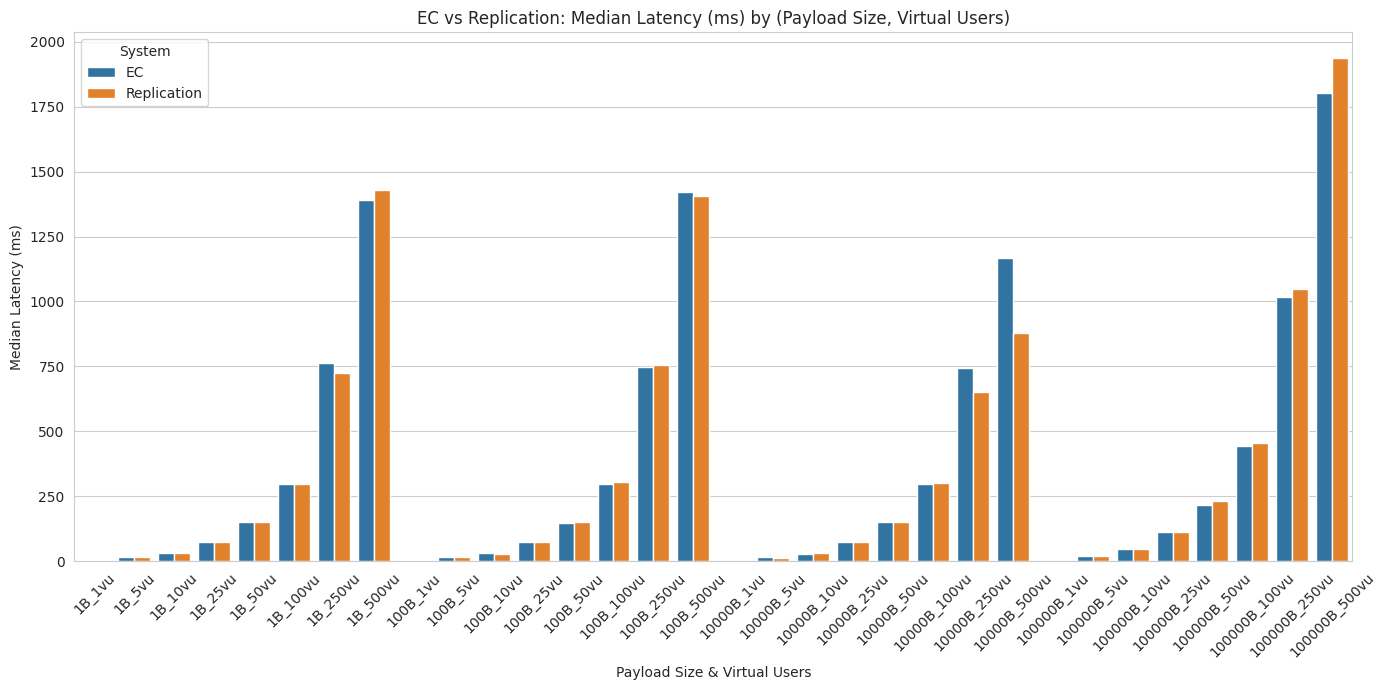

/tmp/ipykernel_725197/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


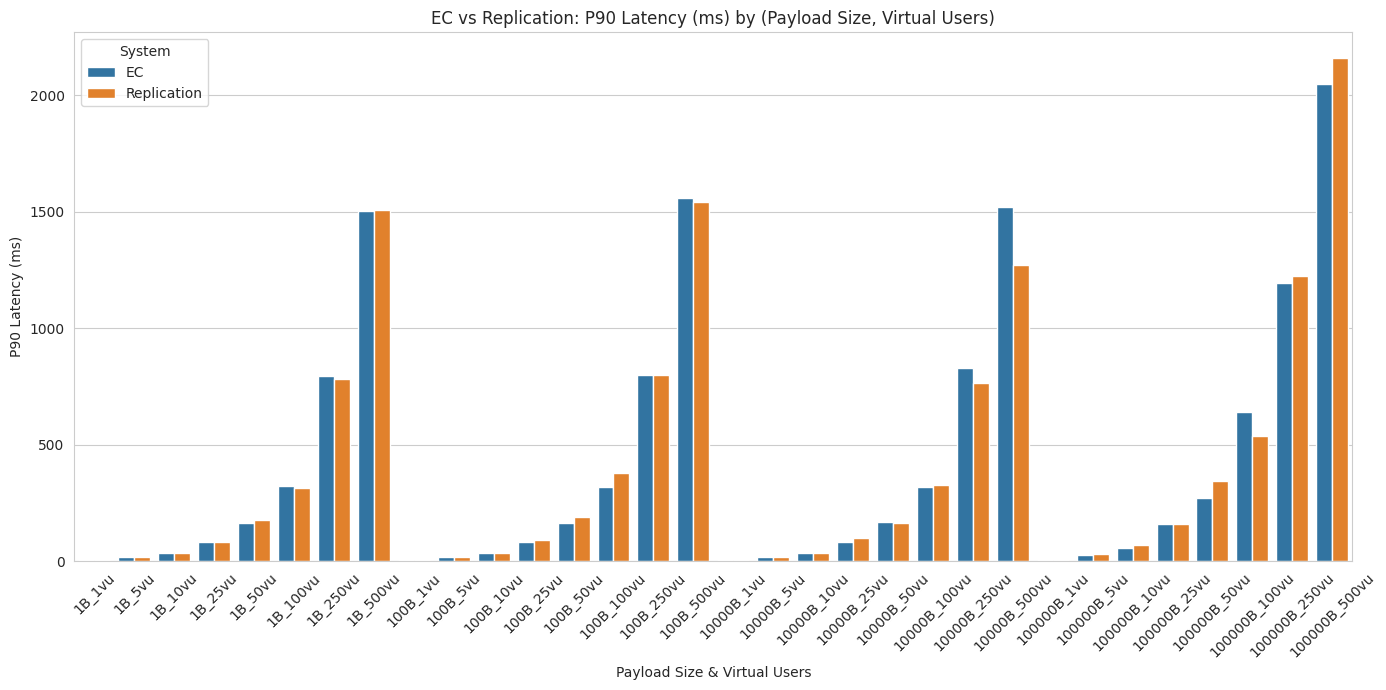

/tmp/ipykernel_725197/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


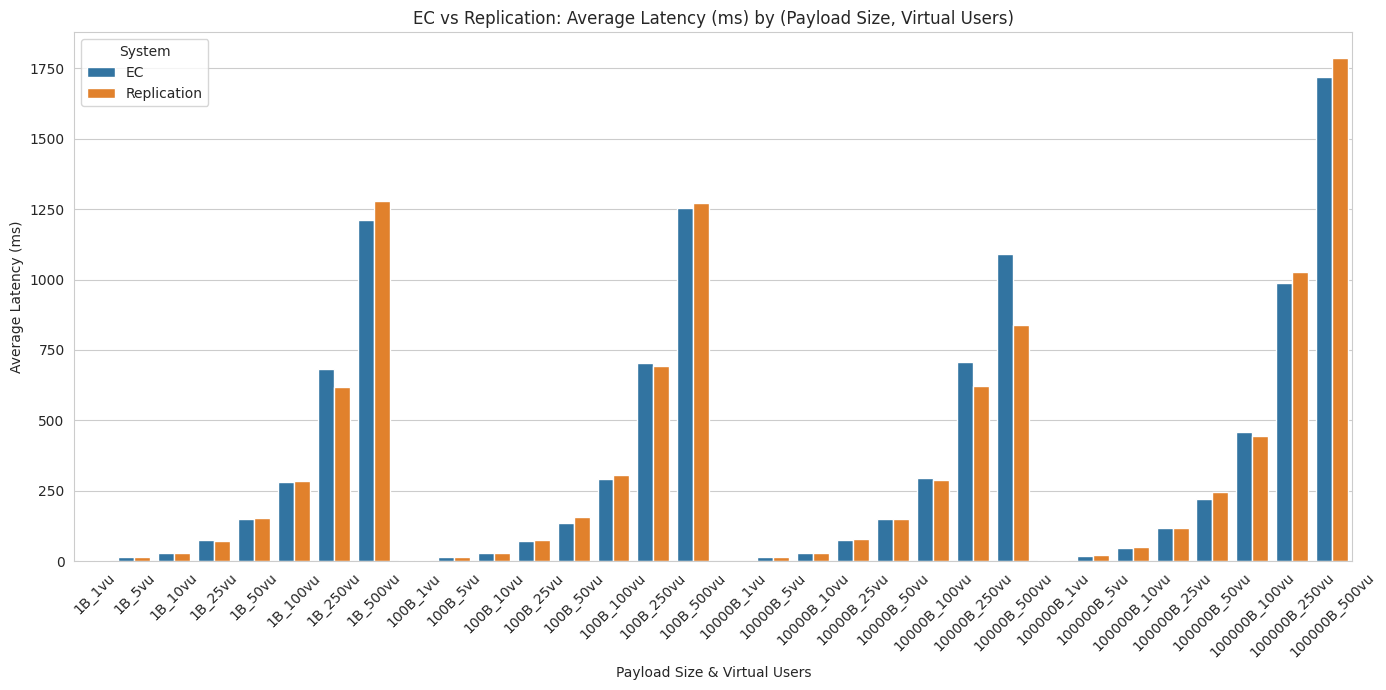

/tmp/ipykernel_725197/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


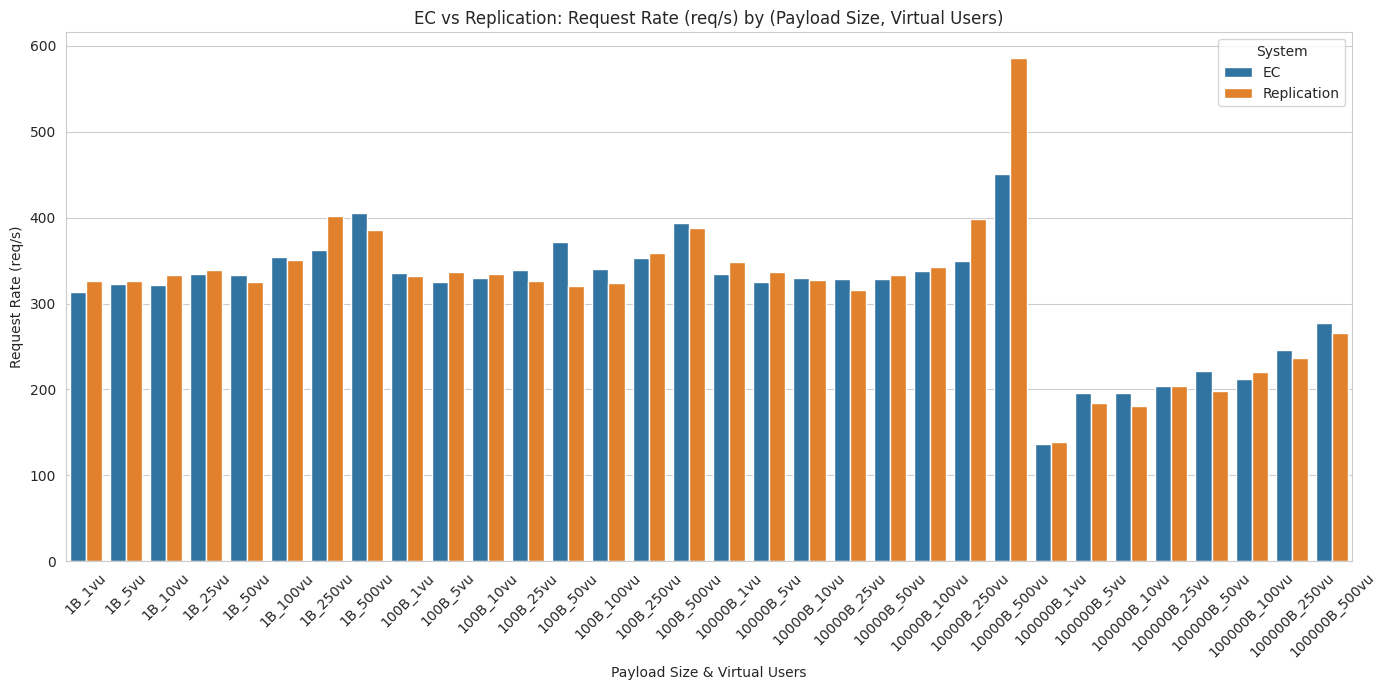

In [6]:
# Plotting: Compare EC vs Replication for each metric, grouped by (payload_size, virtual_user)
sns.set_style("whitegrid")
metrics = ['med', 'p90', 'avg', 'rate']
metric_titles = {'med': 'Median Latency (ms)', 'p90': 'P90 Latency (ms)', 'avg': 'Average Latency (ms)', 'rate': 'Request Rate (req/s)'}

for metric in metrics:
    plt.figure(figsize=(14,7))
    sns.barplot(
        data=df,
        x='combo',
        y=metric,
        hue='system',
        ci=None,
        dodge=True
    )
    plt.title(f'EC vs Replication: {metric_titles[metric]} by (Payload Size, Virtual Users)')
    plt.xlabel('Payload Size & Virtual Users')
    plt.ylabel(metric_titles[metric])
    plt.xticks(rotation=45)
    plt.legend(title='System')
    plt.tight_layout()
    plt.show()